# goes-orthorectify

Orthorectify and clip a GOES ABI image using an input DEM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import goes_ortho

# import get_dem function from https://github.com/uw-cryo/asp-binder-demo/blob/6f03afadc7f4c6e13422da6d5f480c7f6762b47b/asp_binder_utils.py
from asp_binder_utils import get_dem

**Download a DEM** 

I am using [this](https://github.com/uw-cryo/asp-binder-demo/blob/6f03afadc7f4c6e13422da6d5f480c7f6762b47b/asp_binder_utils.py) extremely handy function, `get_dem()` from the [UW Terrain Analysis and Cryosphere Observation Lab](https://github.com/uw-cryo) to download a DEM. We will use this terrain informaiton to orthorectify a portion of a GOES ABI image.

In [2]:
dem_filepath = './dem/tuolumne_dem.tif'

get_dem(demtype='SRTMGL1_E', bounds=(-119.8, 37.5, -118.9, 38.1), out_fn=dem_filepath, proj='EPSG:4326')

'./dem/tuolumne_dem.tif'

Select two GOES ABI images

In [3]:
goes16_image_path = '/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G16_s20200630001139_e20200630003512_c20200630003542.nc'
goes17_image_path = '/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G17_s20200630001176_e20200630003549_c20200630003571.nc'

### Orthorectify and output new NetCDF file:

In [4]:
# create a new filenames
new_goes16_filename = goes16_image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'
new_goes17_filename = goes17_image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'

#### Generate the pixel mapping that relates GOES ABI pixels to points on the DEM surface

In [5]:
# create the mapping between scan angle coordinates and lat/lon given the GOES satellite position and our DEM
goes16_ortho_map = goes_ortho.make_ortho_map(goes16_image_path, 
                                             dem_filepath)

goes17_ortho_map = goes_ortho.make_ortho_map(goes17_image_path, 
                                             dem_filepath)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 2160, longitude: 3240)
Coordinates:
  * longitude       (longitude) float64 -119.8 -119.8 -119.8 ... -118.9 -118.9
  * latitude        (latitude) float64 38.1 38.1 38.1 38.1 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 -0.09106 -0.09106 ... -0.09056
    dem_px_angle_y  (latitude, longitude) float64 0.1011 0.1011 ... 0.09999
Data variables:
    elevation       (latitude, longitude) float32 2117.2366 ... 3168.3154
Attributes:
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                      6378137.0
    semi_

Preview these pixel mappings

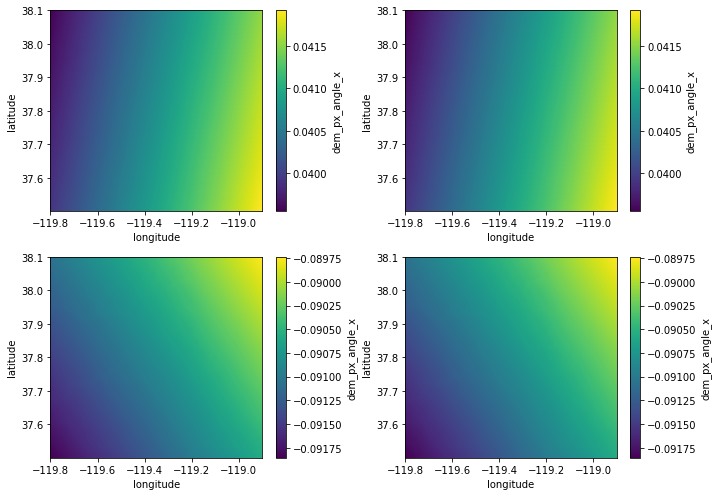

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10,7), tight_layout=True)
[ax1, ax2, ax3, ax4] = ax.flatten()

goes17_ortho_map.dem_px_angle_x.plot(ax=ax1)

goes17_ortho_map.dem_px_angle_x.plot(ax=ax2)

goes16_ortho_map.dem_px_angle_x.plot(ax=ax3)

goes16_ortho_map.dem_px_angle_x.plot(ax=ax4)

#### Apply the pixel mapping to orthorectify the GOES ABI image

In [7]:
# specify which data variables from the original ABI product we want in our new orthorectified file
data_vars = ['Rad'] # I'm only selecting the Radiance product. 

# Note, because we've supplied Radiance to orthorectify_abi(), 
# we will also get reflectance (for bands 1-6) or brightness temperature (for bands 7-16)

# Apply the "ortho map" and save a new NetCDF file with data variables from the original file
goes16_ds = goes_ortho.orthorectify_abi(goes16_image_path, 
                                        goes16_ortho_map,
                                        data_vars,
                                        out_filename=new_goes16_filename)

# Apply the "ortho map" and save a new NetCDF file with data variables from the original file
goes17_ds = goes_ortho.orthorectify_abi(goes17_image_path, 
                                        goes17_ortho_map,
                                        data_vars,
                                        out_filename=new_goes17_filename)


RUNNING: orthorectify_abi_rad()

Does the projection info in the image match our mapping?

Opening GOES ABI image...			ABI image value	Pixel map value
perspective_point_height + semi_major_axis:	42164160.0	42164160.0
semi_major_axis:				6378137.0	6378137.0
semi_minor_axis:				6356752.31414	6356752.31414
longitude_of_projection_origin:			-75.0		-75.0
...done

Map (orthorectify) and clip the image to the pixel map for Rad
...done

Output this result to a new NetCDF file
Saving file as: OR_ABI-L1b-RadC-M6C02_G16_s20200630001139_e20200630003512_c20200630003542_orthorectified.nc
...done

RUNNING: orthorectify_abi_rad()

Does the projection info in the image match our mapping?

Opening GOES ABI image...			ABI image value	Pixel map value
perspective_point_height + semi_major_axis:	42164160.0	42164160.0
semi_major_axis:				6378137.0	6378137.0
semi_minor_axis:				6356752.31414	6356752.31414
longitude_of_projection_origin:			-137.0		-137.0
...done

Map (orthorectify) and clip the image to the p

Preview the orthorectified images

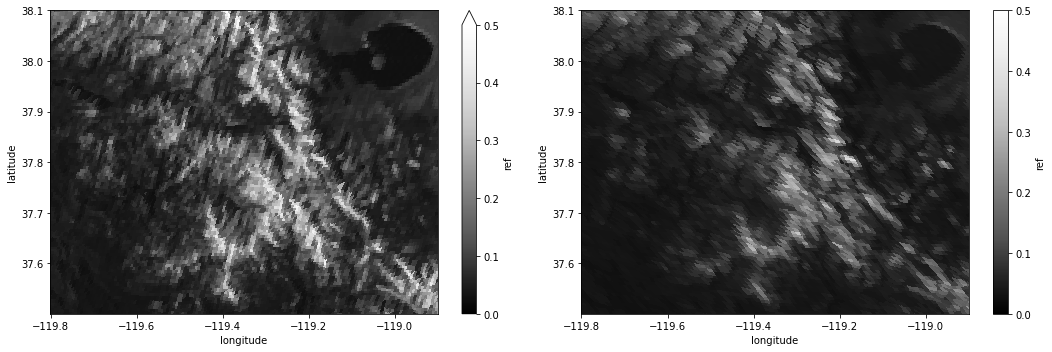

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)

goes17_ds.ref.plot(ax=ax1, cmap='Greys_r', vmin=0, vmax=0.5)

goes16_ds.ref.plot(ax=ax2, cmap='Greys_r', vmin=0, vmax=0.5)